In [2]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sb
import os
import random
from tqdm import tqdm
import pickle
from Bert.custom_tokenizer import WordPieceTokenizer

def reset_random_seeds():
    os.environ['PYTHONHASHSEED']=str(2)
    tf.random.set_seed(2)
    np.random.seed(2)
    
    random.seed(2)
    
tf.config.list_physical_devices('GPU')



I0000 00:00:1729352437.340937    3615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729352437.467439    3615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729352437.467730    3615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# trained tokenizer and long sequence pretraining data
        
if __name__ == "__main__":

    with open('wp_tok_en.pkl','rb') as f:
        tokenizer = pickle.load(f)
        
with open('long_pretraining_data.pkl','rb') as f:
    data = pickle.load(f)

In [4]:
# initialize the model same as 1st phase but input_len would now be 128

from Bert.bert import BERT

reset_random_seeds()

input_len = 128
d_model = 256
n_heads = 8
vocab_size = len(tokenizer.i2w)
units = d_model // 2
n_layers = 2
batch = 64

i = tf.keras.layers.Input((input_len,),batch_size=batch,dtype=tf.int16)

bert_layer = BERT(d_model=d_model,input_len=input_len,
                  n_heads=n_heads,n_layers=n_layers,
                  units=units,vocab_size=vocab_size)
out = bert_layer(i)

out = tf.keras.layers.Dense(vocab_size,activation='softmax')(out)

model = tf.keras.Model(i,out)

# model.load_weights('Bert/bert_mlm_long_4.weights.h5')

model.summary()

I0000 00:00:1729352450.321437    3615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729352450.321785    3615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729352450.321976    3615 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729352450.429821    3615 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bert (BERT)                     │ (64, 128, 256)         │     4,538,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (64, 128, 15020)       │     3,860,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,398,252 (32.04 MB)

 Trainable params: 8,398,252 (32.04 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# set positional encodings and unfreeze the weights for training

model.layers[1].set_positional_encoding()
model.layers[1].embedding.pos_emb_layer.trainable = True

<Axes: >

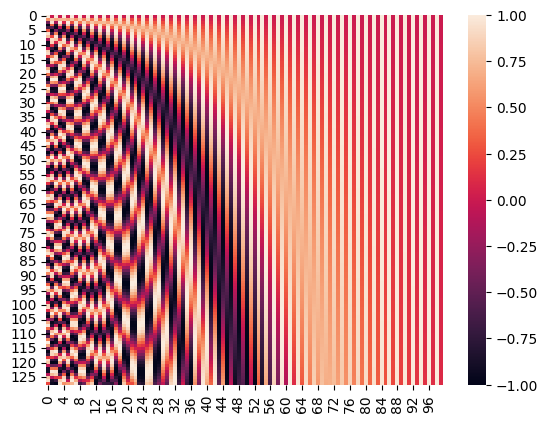

In [6]:
sb.heatmap(model.layers[1].embedding.pos_emb_layer.get_weights()[0][:,:100])

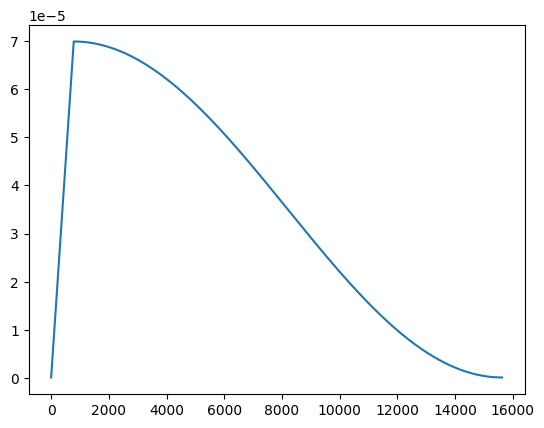

In [7]:
# same as before, but here max_lr would be 7e-5

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01)


class CosineLRScheduler:
    def __init__(self,total_steps,max_lr=7e-5,min_lr=1e-8,init_lr=1e-8):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.init_lr = init_lr
        self.total_setps = total_steps
        self.warmup = int(total_steps * 0.05)
        self.decay = total_steps - self.warmup
        self.warmup_lr = np.linspace(init_lr,max_lr,self.warmup)
        
        
    def __call__(self,step):
        
        if step <= self.warmup:
            
            lr = self.warmup_lr[step-1]
        else:   
            step = step - self.warmup
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(step * np.pi / self.decay))
        
        return lr


    
    
xtrain = data['train']['masked_seq']
ytrain = data['train']['seq']

xvalid = data['valid']['masked_seq']
yvalid = data['valid']['seq']



total_steps = len(xtrain) // batch + 1
    

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=batch,drop_remainder=True).shuffle(buffer_size=100)

valid = tf.data.Dataset.from_tensor_slices((xvalid,yvalid)).batch(batch_size=batch)

lr_scheduler = CosineLRScheduler(total_steps)

plt.plot([lr_scheduler(step) for step in range(1,total_steps+1)])


In [8]:
mask_token = tokenizer.w2i['<mask>']

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        loss = loss_fn(y,pred,sample_weight=x==mask_token)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss


@tf.function
def test_step(x,y):
    pred = model(x,training=False)
    loss = loss_fn(y,pred,sample_weight=x==mask_token)
    return loss

In [9]:
# till = 5

# for i in range(1,till+1):
#     model.load_weights(f'Bert/bert_mlm_long_{i}.weights.h5')
    
#     loss = 0
#     for i,(x,y) in enumerate(tqdm(valid)):
#         loss += test_step(x,y)
        
    
#     loss = np.round((loss / (i+1)).numpy(),4) 
    
#     print(i,'\t',loss)
    
# # # i = 7
# # # model.load_weights(f'Bert/bert_mlm_long_{i}.weights.h5') 

In [10]:
# predicted tokens and attention plots before tranfser learning

def sample_output(x,y):
    
    masked_idx = np.where(x == mask_token)[0]
    x = x[tf.newaxis,:]
    p = model(x)[0]
    p = np.argmax(p,axis=-1)
    pred_masked = p[masked_idx]
    pred_masked = [tokenizer.i2w[t] for t in pred_masked]
    print('predicted tokens :',pred_masked)
    masked_target = y[masked_idx]
    masked_target = [tokenizer.i2w[t] for t in masked_target]
    print('actual tokens :',masked_target)

i = 100
x_sample = data['valid']['masked_seq'][i]
y_sample = data['valid']['seq'][i]
idx = np.where(x_sample!=0)[0][-1]
print(' '.join([tokenizer.i2w[t] for t in x_sample if t>0]))
print()
sample_output(x_sample,y_sample)

<cls> <mask> motors won an ar ##bit ##ra ##l award of ' <mask> ##6 ##5 . 7 ##8 <mask> plus interest to <mask> for its investment in the now - scrap ##p ##ed sing ##u ##r plant . it was building the plant in sing ##u <mask> to manufacture tata nan ##o <mask> the company is entitled <mask> recover ' 7 ##6 ##5 . 7 ##8 crore with 11 % p . a . interest from september 1 , <mask> , till the actual recovery <mask> ##o ##f <mask> west bengal industrial development corporation limited <mask> <sep>

predicted tokens : ['dg', 'rodent', 'rodent', 'rodent', 'rodent', 'dg', 'dg', 'rodent', 'rodent', 'rodent', 'dg']
actual tokens : ['tata', '7', 'crore', 'compensate', '##r', '.', 'to', '2016', 'there', 'from', '.']


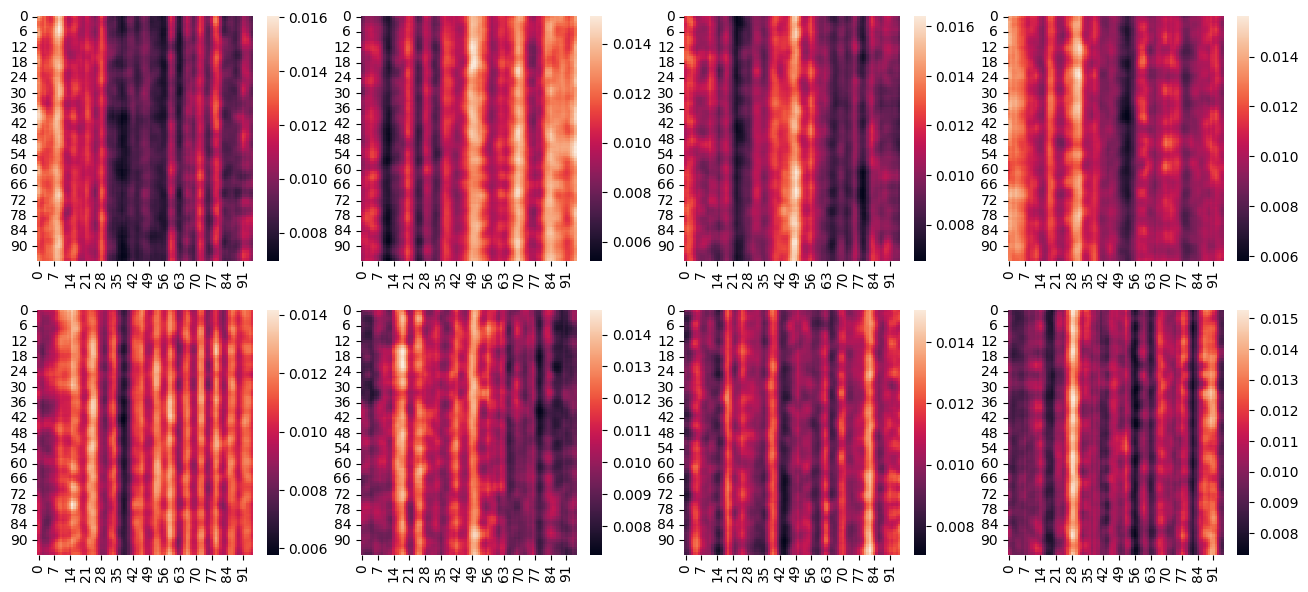

In [11]:
attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])

plt.show()
print()  

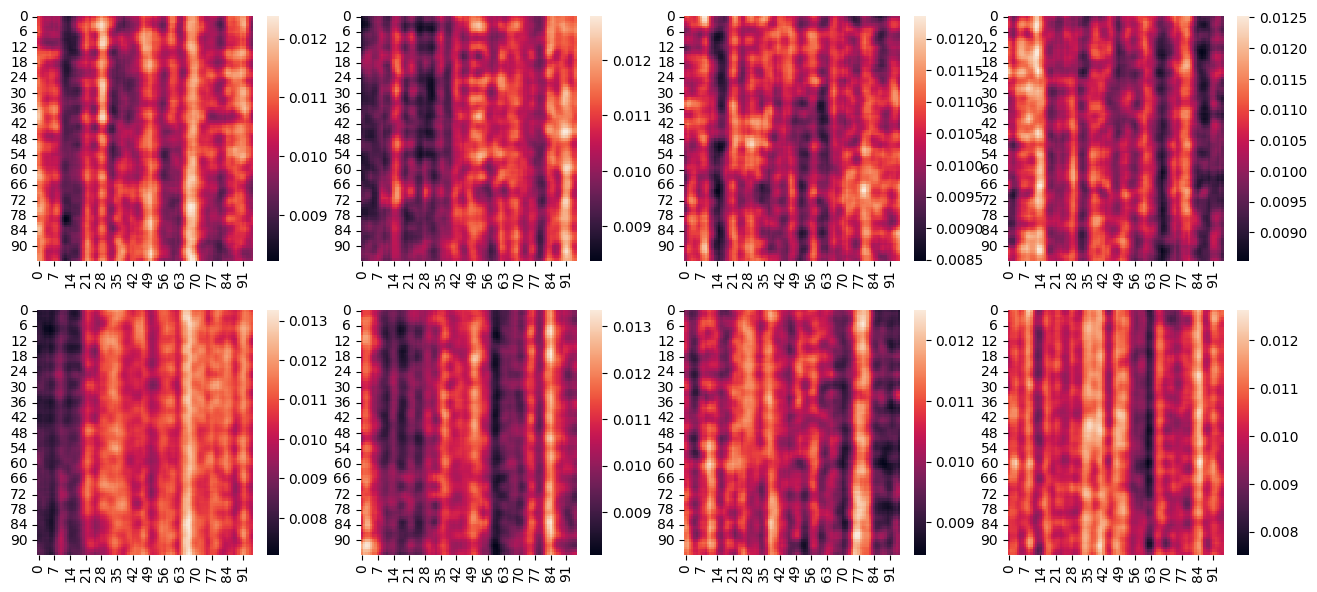

In [12]:
attn_scores = model.layers[1].encoder_layers[0].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])

plt.show()
print()  

In [14]:
# load weights from 1st phase

with open('Bert/pretrained_embeddings_weights.pkl','rb') as f:
    pretrained_emb = pickle.load(f)

with open('Bert/pretrained_encoder_weights.pkl','rb') as f:
    pretrained_en = pickle.load(f)
    
with open('Bert/mlm_head.pkl','rb') as f:
    mlm_head = pickle.load(f)
    
model.layers[1].embedding.word_emb_layer.set_weights(pretrained_emb)
model.layers[1].encoder_layers[0].set_weights(pretrained_en[0])
model.layers[1].encoder_layers[1].set_weights(pretrained_en[1])
model.layers[-1].set_weights(mlm_head)

# model.load_weights('')

In [15]:
# predicted tokens and attention plots after tranfser learning

i = 10
x_sample = data['valid']['masked_seq'][i]
y_sample = data['valid']['seq'][i]
idx = np.where(x_sample!=0)[0][-1]
print(' '.join([tokenizer.i2w[t] for t in x_sample if t>0]))
print()
sample_output(x_sample,y_sample)

<cls> as he settles into <mask> seat , he sees bart arriving on horseback outside the theatre . bart blocks lamar ##r ' s escape , and then shoots him in the <mask> ##o ##in . bart and jim then <mask> into gr ##a ##u ##man ' s to watch the end of the film , in which <mask> announces to <mask> townspeople that he is moving on . riding out <mask> town , <mask> <mask> jim , and invites him along to " <mask> special " . they ride off into the <mask> in a <mask> ##ed stretch limousine . <sep>

predicted tokens : ['a', 'two', '19', 'and', 'another', 'another', 'another', 'another', 'another', 'in', 'in']
actual tokens : ['his', 'gr', 'go', 'bart', 'the', 'of', 'he', 'finds', 'nowhere', 'sunset', 'chauffeur']


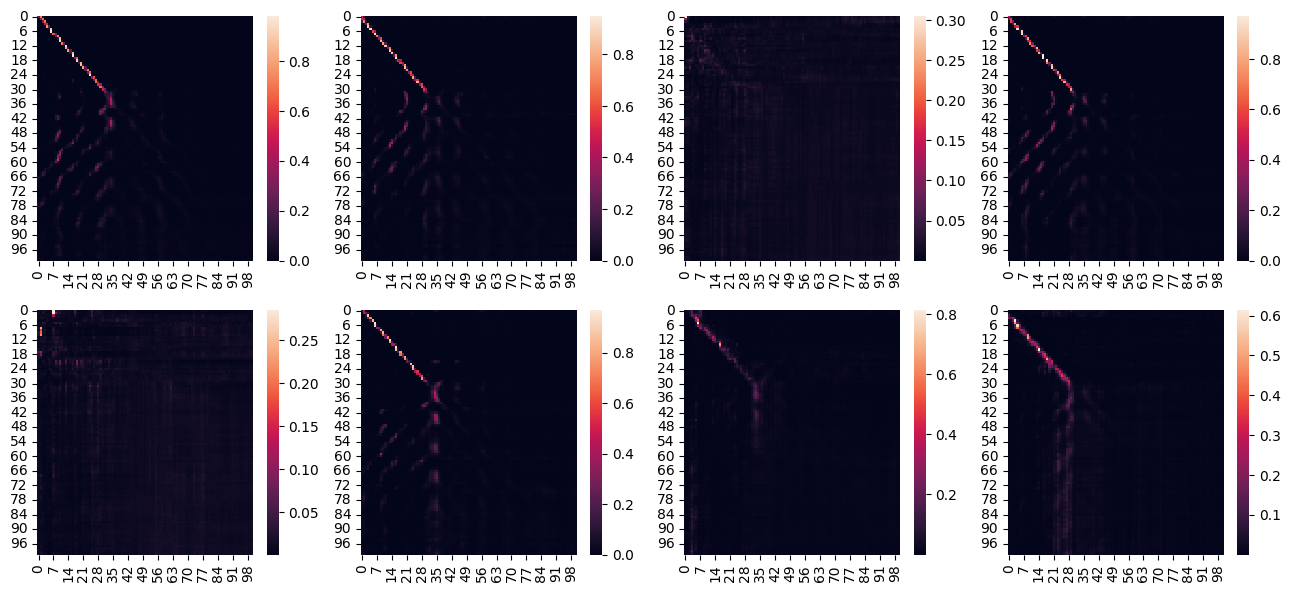

In [16]:
attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])

plt.show()
print()  

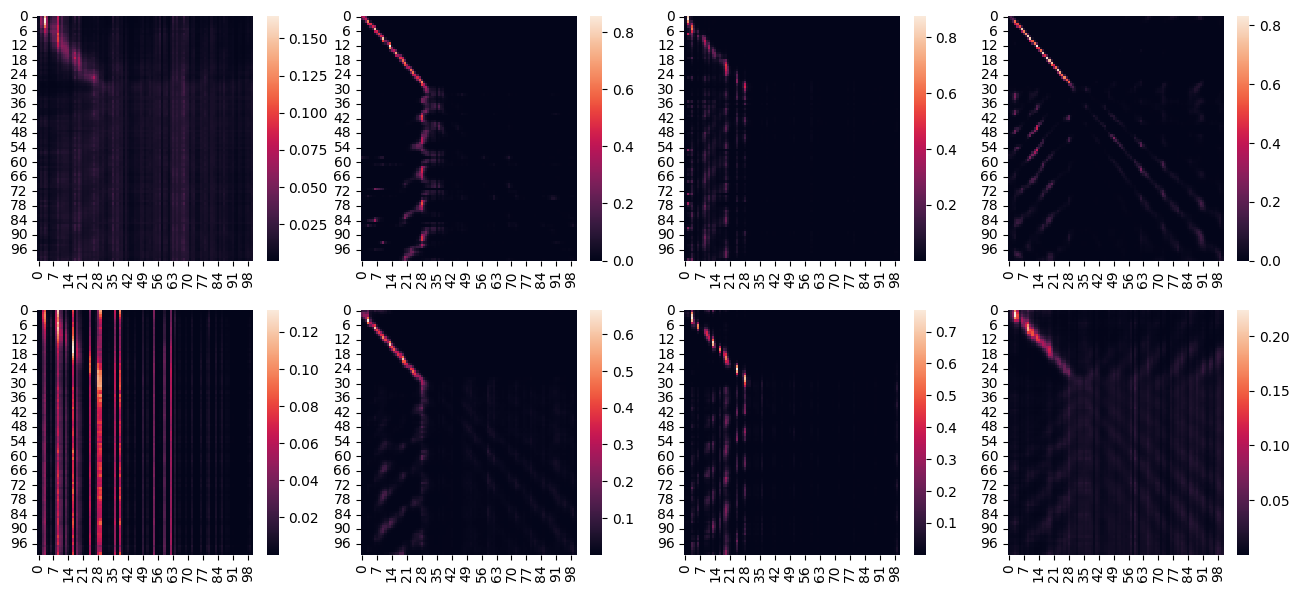

In [17]:
attn_scores = model.layers[1].encoder_layers[0].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])

plt.show()
print()  

In [18]:
# loss = 0
# for i,(x,y) in enumerate(tqdm(valid)):
#     loss += test_step(x,y)


# loss = np.round((loss / (i+1)).numpy(),4) 
# loss

EPOCH : 1/6


100%|███████████████████████████████████████| 2126/2126 [01:56<00:00, 18.23it/s]


train_loss : 0.2174
val_loss : 0.1867
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> as he settles into <mask> seat , he sees bart arriving on horseback outside the theatre . bart blocks lamar ##r ' s escape , and then shoots him in the <mask> ##o ##in . bart and jim then <mask> into gr ##a ##u ##man ' s to watch the end of the film , in which <mask> announces to <mask> townspeople that he is moving on . riding out <mask> town , <mask> <mask> jim , and invites him along to " <mask> special " . they ride off into the <mask> in a <mask> ##ed stretch limousine . <sep>


predicted tokens : ['a', 'back', 'runs', 'he', 'the', 'the', 'and', 'and', 'a', 'house', 'chair']
actual tokens : ['his', 'gr', 'go', 'bart', 'the', 'of', 'he', 'finds', 'nowhere', 'sunset', 'chauffeur']


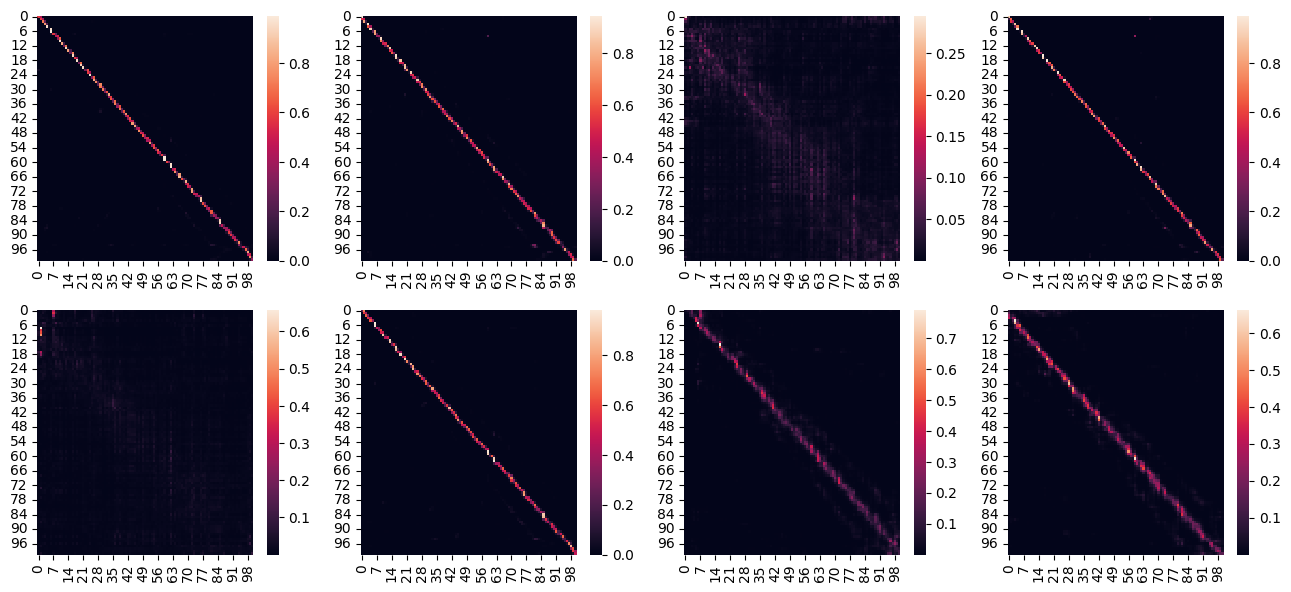


EPOCH : 2/6


100%|███████████████████████████████████████| 2126/2126 [01:55<00:00, 18.34it/s]


train_loss : 0.1896
val_loss : 0.1781
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> as he settles into <mask> seat , he sees bart arriving on horseback outside the theatre . bart blocks lamar ##r ' s escape , and then shoots him in the <mask> ##o ##in . bart and jim then <mask> into gr ##a ##u ##man ' s to watch the end of the film , in which <mask> announces to <mask> townspeople that he is moving on . riding out <mask> town , <mask> <mask> jim , and invites him along to " <mask> special " . they ride off into the <mask> in a <mask> ##ed stretch limousine . <sep>


predicted tokens : ['a', 'tr', 'runs', 'he', 'the', 'the', 'and', 'and', 'a', 'house', 'bid']
actual tokens : ['his', 'gr', 'go', 'bart', 'the', 'of', 'he', 'finds', 'nowhere', 'sunset', 'chauffeur']


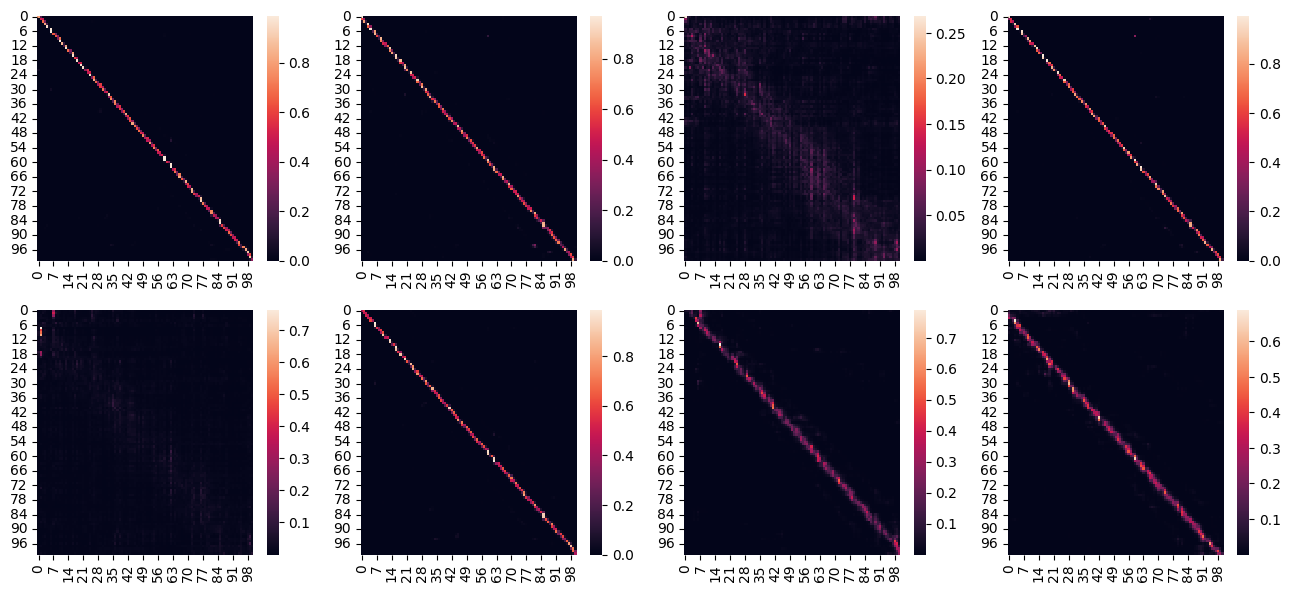


EPOCH : 3/6


100%|███████████████████████████████████████| 2126/2126 [01:55<00:00, 18.36it/s]


train_loss : 0.1825
val_loss : 0.1742
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> as he settles into <mask> seat , he sees bart arriving on horseback outside the theatre . bart blocks lamar ##r ' s escape , and then shoots him in the <mask> ##o ##in . bart and jim then <mask> into gr ##a ##u ##man ' s to watch the end of the film , in which <mask> announces to <mask> townspeople that he is moving on . riding out <mask> town , <mask> <mask> jim , and invites him along to " <mask> special " . they ride off into the <mask> in a <mask> ##ed stretch limousine . <sep>


predicted tokens : ['a', 'tr', 'runs', 'he', 'the', 'the', 'and', 'with', 'a', 'city', 'bid']
actual tokens : ['his', 'gr', 'go', 'bart', 'the', 'of', 'he', 'finds', 'nowhere', 'sunset', 'chauffeur']


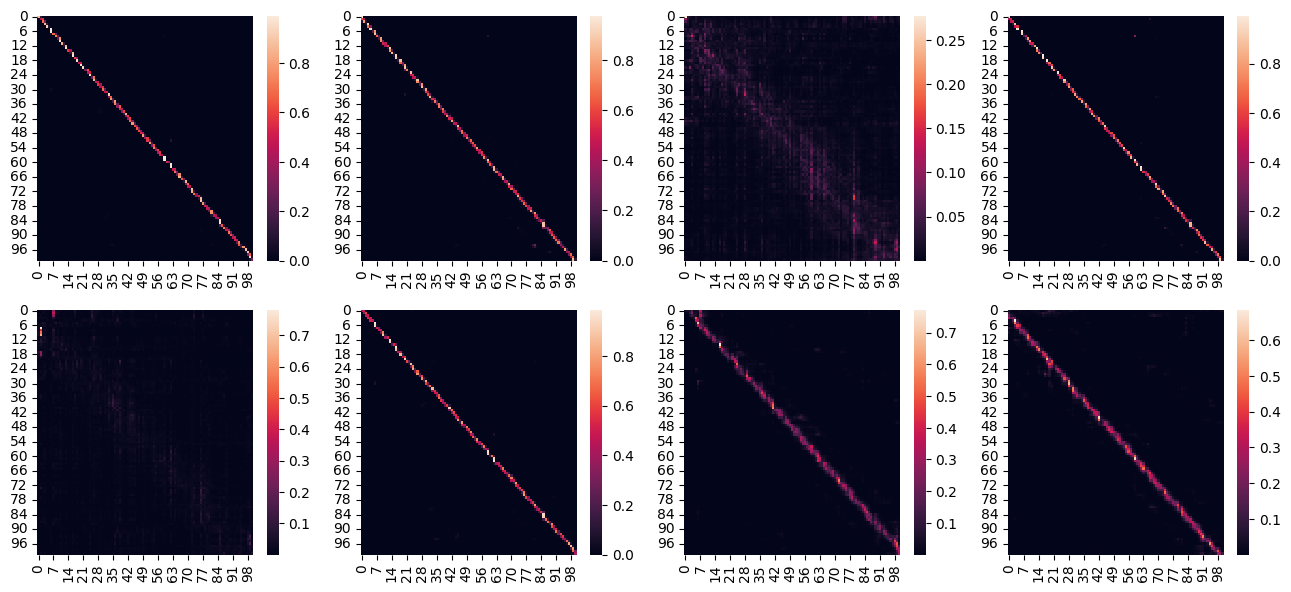


EPOCH : 4/6


100%|███████████████████████████████████████| 2126/2126 [01:55<00:00, 18.35it/s]


train_loss : 0.1778
val_loss : 0.1716
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> as he settles into <mask> seat , he sees bart arriving on horseback outside the theatre . bart blocks lamar ##r ' s escape , and then shoots him in the <mask> ##o ##in . bart and jim then <mask> into gr ##a ##u ##man ' s to watch the end of the film , in which <mask> announces to <mask> townspeople that he is moving on . riding out <mask> town , <mask> <mask> jim , and invites him along to " <mask> special " . they ride off into the <mask> in a <mask> ##ed stretch limousine . <sep>


predicted tokens : ['a', 'tr', 'runs', 'he', 'the', 'of', 'and', 'with', 'a', 'city', 'bid']
actual tokens : ['his', 'gr', 'go', 'bart', 'the', 'of', 'he', 'finds', 'nowhere', 'sunset', 'chauffeur']


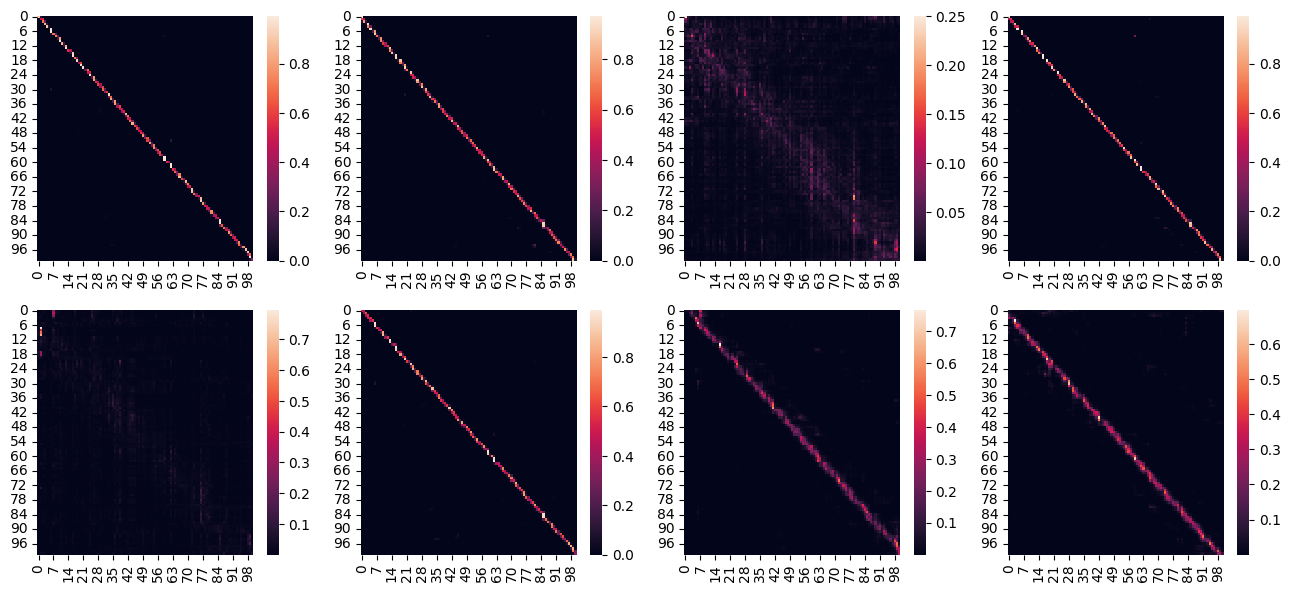


EPOCH : 5/6


100%|███████████████████████████████████████| 2126/2126 [01:55<00:00, 18.34it/s]


train_loss : 0.1742
val_loss : 0.1697
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> as he settles into <mask> seat , he sees bart arriving on horseback outside the theatre . bart blocks lamar ##r ' s escape , and then shoots him in the <mask> ##o ##in . bart and jim then <mask> into gr ##a ##u ##man ' s to watch the end of the film , in which <mask> announces to <mask> townspeople that he is moving on . riding out <mask> town , <mask> <mask> jim , and invites him along to " <mask> special " . they ride off into the <mask> in a <mask> ##ed stretch limousine . <sep>


predicted tokens : ['a', 'tr', 'runs', 'he', 'the', 'of', 'where', 'with', 'a', 'city', 'bid']
actual tokens : ['his', 'gr', 'go', 'bart', 'the', 'of', 'he', 'finds', 'nowhere', 'sunset', 'chauffeur']


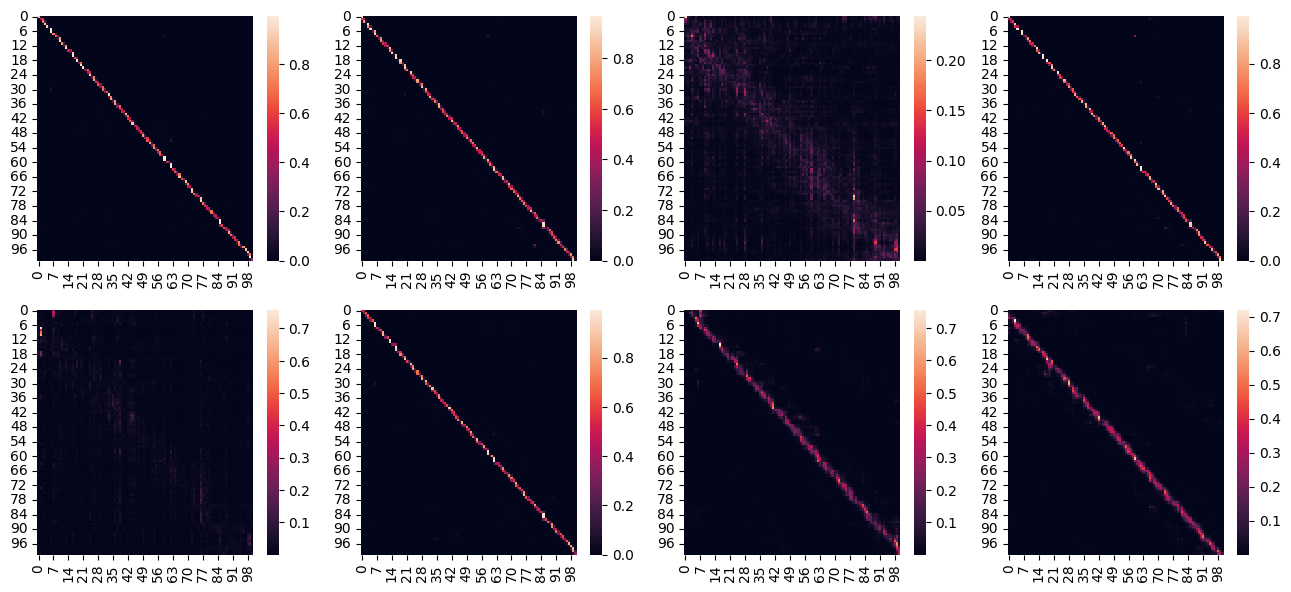


EPOCH : 6/6


100%|███████████████████████████████████████| 2126/2126 [01:55<00:00, 18.40it/s]


train_loss : 0.1713
val_loss : 0.1682
weights saved
------------------------------------------------------------------------------------------
INPUT : <cls> as he settles into <mask> seat , he sees bart arriving on horseback outside the theatre . bart blocks lamar ##r ' s escape , and then shoots him in the <mask> ##o ##in . bart and jim then <mask> into gr ##a ##u ##man ' s to watch the end of the film , in which <mask> announces to <mask> townspeople that he is moving on . riding out <mask> town , <mask> <mask> jim , and invites him along to " <mask> special " . they ride off into the <mask> in a <mask> ##ed stretch limousine . <sep>


predicted tokens : ['a', 'tr', 'runs', 'he', 'the', 'of', 'where', 'with', 'a', 'city', 'bid']
actual tokens : ['his', 'gr', 'go', 'bart', 'the', 'of', 'he', 'finds', 'nowhere', 'sunset', 'chauffeur']


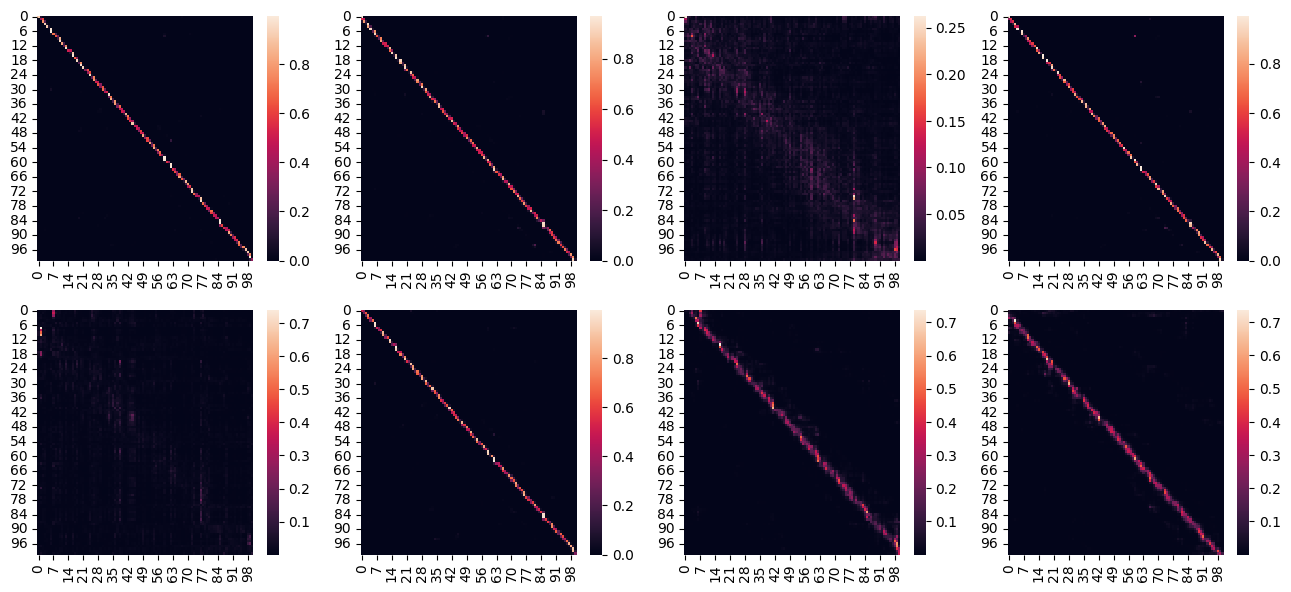

In [17]:
# start pretraining (2nd Phase)

epochs = 6

losses = {'train':[],'valid':[]}
check = []
for e in range(1,epochs+1):
    
    print(f'EPOCH : {e}/{epochs}')
    
    loss = 0
    for i,(x,y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y)
        
    train_loss = np.round((loss / (i+1)).numpy(),4)
#     print(train_loss)
    
    losses['train'].append(train_loss)
    loss = 0
    for i,(x,y) in enumerate(tqdm(valid)):
        loss += test_step(x,y)
        
    
    loss = np.round((loss / (i+1)).numpy(),4) 
    
    print('train_loss :',train_loss)
    print('val_loss :',loss)
    
    if e == 1:
        model.save_weights(f'Bert/bert_mlm_long_{e}.weights.h5')
        print('weights saved')
        
    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights(f'Bert/bert_mlm_long_{e}.weights.h5')
        print('weights saved')
    
    losses['valid'].append(loss)
    
    print('------------------------------------------------------------------------------------------')
    
    inp = ' '.join([tokenizer.i2w[t] for t in x_sample if t>0])
    
    print('INPUT :',inp+'\n')
    print()
    sample_output(x_sample,y_sample)
    
    
    
    attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

    _,ax = plt.subplots(2,4,figsize=(16,7))

    for i in range(2):
        for j in range(4):
            sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])

    plt.show()
    print()    


<cls> USER USER but <mask> do ##l <mask> ##h ##in will never see <mask> again ! i was going to mention dog but all the li ##ck ##in ##g a bit inappropriate <sep>
predicted tokens : ['i', '##c', 'it']
actual tokens : ['the', '##p', 'him']


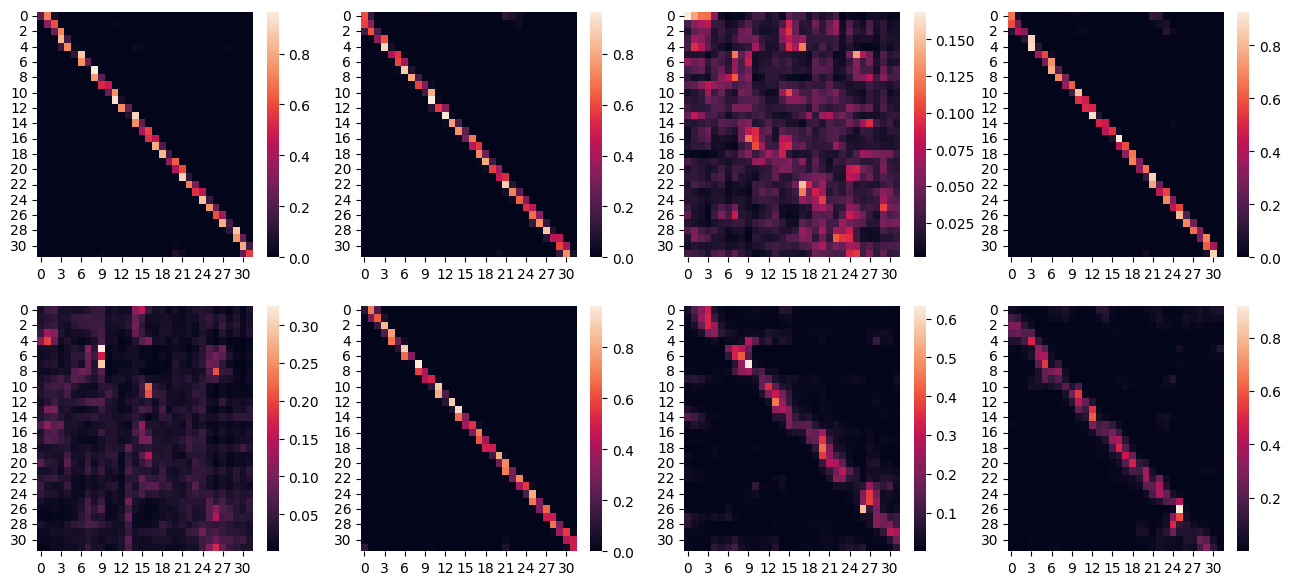

In [19]:
i = np.random.randint(0,len(xvalid)-1)
x = xvalid[i]
y = yvalid[i]

print(' '.join([tokenizer.i2w[t] for t in x if t>0]))

sample_output(x,y)

idx = np.where(x!=0)[0][-1]

attn_scores = model.layers[1].encoder_layers[-1].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()

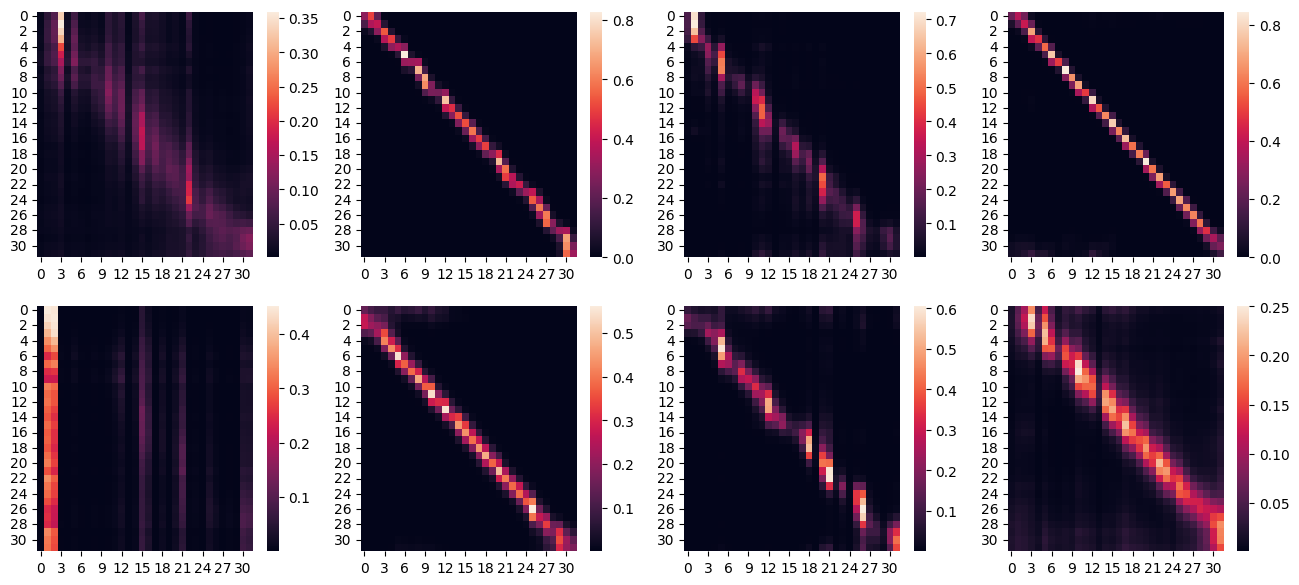

In [20]:
attn_scores = model.layers[1].encoder_layers[0].attention.attention_scores.numpy()[0,:,:idx,:idx]

_,ax = plt.subplots(2,4,figsize=(16,7))

for i in range(2):
    for j in range(4):
        sb.heatmap(np.reshape(attn_scores,(2,4,idx,idx))[i][j],ax=ax[i][j])
        
plt.show()

In [13]:
# load best weights

model.load_weights('Bert/bert_mlm_long_6.weights.h5')

<Axes: >

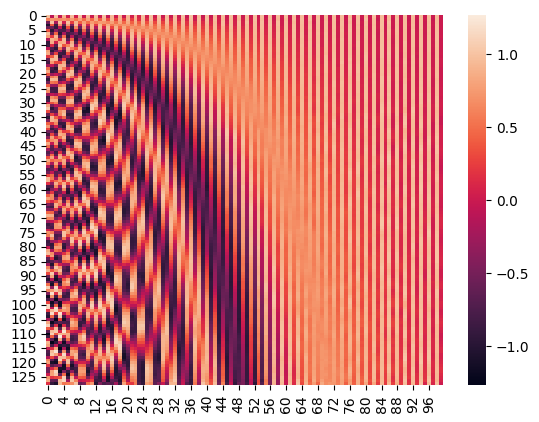

In [22]:
# visualize trained positional encodings

sb.heatmap(model.layers[1].embedding.pos_emb_layer.get_weights()[0][:,:100])

In [23]:
# save pretrained model

model.save('Bert/BERT_pretrainded.keras')

In [27]:
# check predictions for a random sample

idx = 101010

out = data['valid']['seq'][idx]
print(' '.join(tokenizer.i2w[t] for t in out if t>0))

<cls> chuck and wally sneak onto the boat in order to get evidence of the theft . chuck finds a briefcase full of incriminating evidence , including the porsche ' s original license plate . the four flee on wet ##bi ##ke ##s , steal k ##r ##e ##vs ##ke ' s ferrari , and agree to work together to steal back the porsche . chuck and michelle spend the night together on a cat ##am ##a ##ra ##n on the beach . the next day , with michelle ' s help , chuck and wally steal back the porsche . they present k ##r ##e ##vs ##ke ' s ferrari to the pageant as a replacement grand prize , and give the police the incriminating evidence <sep>


In [28]:
seq = data['valid']['masked_seq'][idx]
print(' '.join(tokenizer.i2w[t] for t in seq if t>0))

<cls> chuck <mask> wally sneak onto the boat in order to get evidence of the theft . chuck finds a briefcase full of incriminating evidence , including the porsche ' s original license plate . the four flee on wet ##bi ##ke ##s , steal k ##r ##e ##vs ##ke ' <mask> ferrari , and agree to <mask> together to steal back <mask> porsche . chuck and michelle spend <mask> night <mask> <mask> <mask> cat ##am ##a ##ra ##n on <mask> <mask> . <mask> <mask> day , with michelle ' s help , chuck and wally steal back the porsche . they present <mask> ##r ##e ##vs ##ke <mask> s ferrari to the pageant as a replacement grand prize , and give the police <mask> incriminating evidence <sep>


In [29]:

tokenizer.maxlen = 128
masked_pos = np.where(np.array(seq) == 4)[0]
seq = np.array(tokenizer.add_padding(seq))

masked_pos


array([  2,  51,  57,  62,  69,  71,  72,  73,  80,  81,  83,  84, 103,
       108, 124])

In [30]:
pred = model(seq[np.newaxis,:])[0].numpy()
masked_pred = np.argmax(pred,axis=-1)[masked_pos]

In [31]:
# predicted tokens

print([tokenizer.i2w[t] for t in masked_pred])

['and', 's', 'go', 'the', 'the', 'with', 'the', 'the', 'the', 'train', 'the', 'one', 'sa', "'", 'and']


In [32]:
# actual tokens

print([tokenizer.i2w[t] for t in out[masked_pos]])

['and', 's', 'work', 'the', 'the', 'together', 'on', 'a', 'the', 'beach', 'the', 'next', 'k', "'", 'the']


In [33]:
# loss per masked token

tf.losses.sparse_categorical_crossentropy(out[masked_pos][:,np.newaxis],pred[masked_pos]).numpy()

array([1.4528751e+00, 1.2418564e-02, 3.5048537e+00, 1.5578657e+00,
       5.1318800e-01, 4.4037189e+00, 4.0718012e+00, 2.7079570e+00,
       6.7357033e-01, 4.8446412e+00, 1.7178984e+00, 1.3822229e+00,
       3.7727122e+00, 3.7485349e-03, 3.9742377e+00], dtype=float32)

In [34]:
# mean loss

tf.losses.sparse_categorical_crossentropy(out[masked_pos][:,np.newaxis],pred[masked_pos]).numpy().mean()

2.3062475

In [14]:
embeddings = model.layers[1].embedding.word_emb_layer.get_weights()[0]
embeddings.shape

(15020, 256)

In [15]:
with open('Bert/bert_word_embeddings.pkl','wb') as f:
    
    pickle.dump(embeddings,f)

In [84]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

In [98]:
m1 = embeddings[tokenizer.w2i['father']]
f1 = embeddings[tokenizer.w2i['mother']]

m2 = embeddings[tokenizer.w2i['man']]
f2 = embeddings[tokenizer.w2i['woman']]

diff1 = np.absolute(m1 - f1)
diff2 = np.absolute(m2 - f2)

cosine_similarity(diff1,diff2)

0.6290903

In [96]:
tokenizer.i2w

{0: '<pad>',
 1: '<cls>',
 2: '<sep>',
 3: '<unk>',
 4: '<mask>',
 5: 'USER',
 6: 'LINK',
 7: '##8',
 8: '##2',
 9: '##7',
 10: '##4',
 11: '##6',
 12: '##3',
 13: '##9',
 14: '##5',
 15: '##1',
 16: 'j',
 17: '##s',
 18: '##x',
 19: '4',
 20: '5',
 21: '2',
 22: '3',
 23: '##h',
 24: '6',
 25: '##yy',
 26: '7',
 27: '8',
 28: '##z',
 29: '9',
 30: '##th',
 31: '##0',
 32: '18',
 33: '##k',
 34: '19',
 35: '##rr',
 36: '##y',
 37: 'v',
 38: '##d',
 39: 'x',
 40: '##p',
 41: 'b',
 42: '##g',
 43: 'q',
 44: '0',
 45: '##m',
 46: '##t',
 47: '##v',
 48: '##ss',
 49: '##a',
 50: '##j',
 51: '##tt',
 52: '##r',
 53: '##q',
 54: '##n',
 55: 'f',
 56: '##w',
 57: 'm',
 58: 'raj',
 59: '##uu',
 60: '##b',
 61: 'z',
 62: '##ll',
 63: '10',
 64: '##o',
 65: '##am',
 66: '##gg',
 67: '20',
 68: '17',
 69: '##c',
 70: '##l',
 71: 'ex',
 72: 't',
 73: 's',
 74: '##f',
 75: '##e',
 76: '##ii',
 77: '##dd',
 78: 'c',
 79: 'g',
 80: 'w',
 81: '##20',
 82: '##09',
 83: '1',
 84: 'p',
 85: '##30',
 86: 

In [76]:
np.mean(diff1 - diff2)

0.00099785